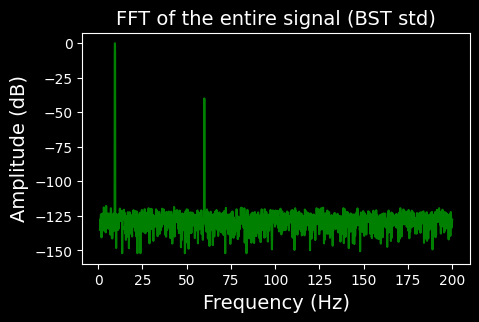

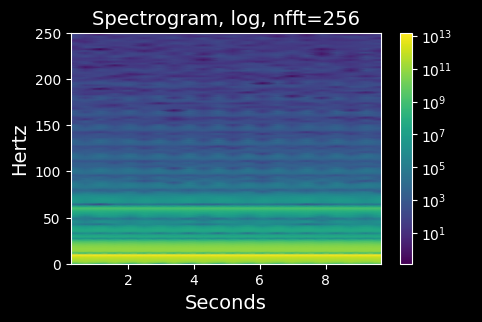

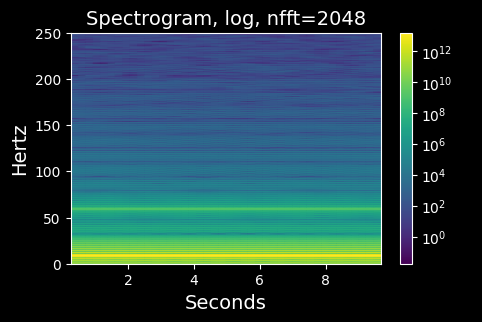

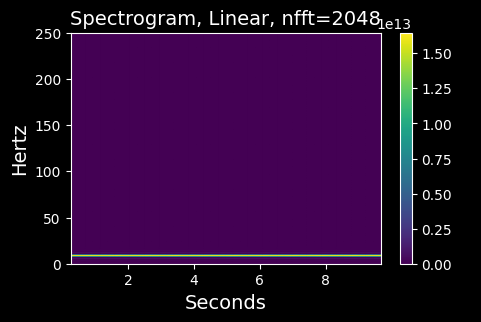

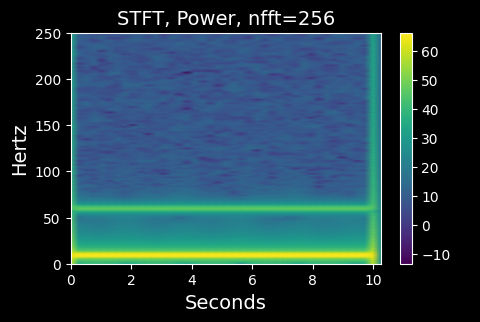

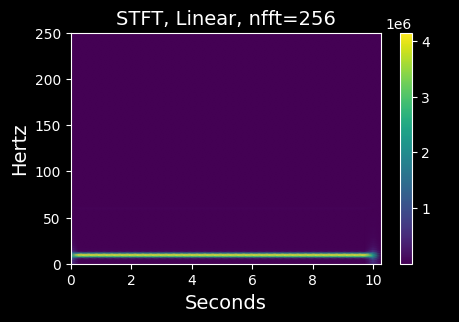

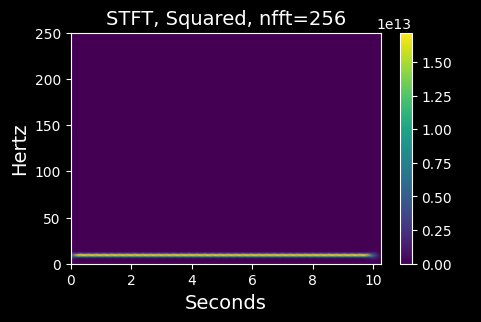

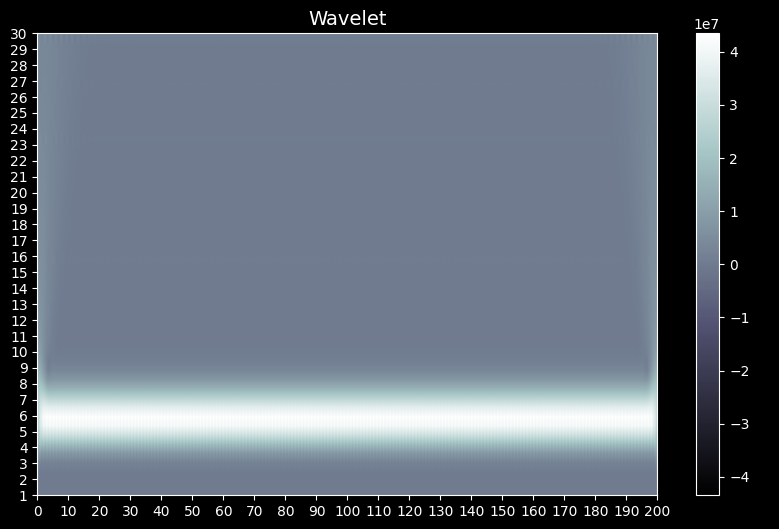

In [25]:
"""
    le-test-1.ipynb
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style 
from scipy.signal import spectrogram, stft, windows
import pywt
from scipy.signal import butter, lfilter


def main():

    t_buf_size = 5000
    samples_per_second = 500

    freq_low = 1
    freq_high = 200

    num_scales = 50
    wavelet = "cgau5"
    scale_low = 1
    scale_high = 200

    t_buf: np.ndarray = np.zeros(t_buf_size, dtype=int)
    t_buf = simulated_data(t_buf_size, samples_per_second)

    dt = 1.0 / float(samples_per_second)
    t_max = float(t_buf_size) / float(samples_per_second)     # max seconds of time-domain data
    t = np.linspace(0, t_max, samples_per_second, endpoint=False)


    # ========== BST:  fft of entire signal (my usual stuff just to verify clean sines and BST amplitude mapping):
    bin_width_Hz = float(samples_per_second) / float(t_buf_size)
    # --- array of bin center freqs (with no dc element) (length num_samples/2)
    bin_center_freqs: np.ndarray = np.fft.rfftfreq(t_buf_size, dt)
    # --- select a range of freqs (as limited by freq_low/high):
    #       (get indices of elements in bin_center_freqs array)
    range_indices: tuple[np.ndarray[any, np.dtype[np.signedinteger]], ...] \
        = np.where(np.logical_and(np.greater_equal(bin_center_freqs, freq_low),
                                    np.less_equal(bin_center_freqs, freq_high)))
    # --- array of freqs in Hz, limited to flow/fhigh range:
    range_freqs = bin_center_freqs[range_indices]
    # --- scale sample data for fft:
    sample_buf: np.ndarray = t_buf[:t_buf_size] / 419430000
    # --- fft-window function:
    sample_buf *= windows.hann(t_buf_size, sym=False)
    #   with amplitude normalization:
    sample_buf *= 2.00
    # --- calc rfft (real input):
    raw_fft: np.ndarray[any, np.dtype[np.complexfloating[_64Bit, _64Bit]]]  \
        = np.fft.rfft(sample_buf) / t_buf_size  # returns (num_samples/2)+1
    # --- fft values converted to magnitude volts pk-pk:
    #       (cereset/bst uses pk-pk)
    mag_volts_pp = abs(raw_fft) * 4  # (num_samples/2)+1
    # or, could convert to volts rms:
    #   (mag_volts_rms = np.sqrt(np.mean(mag_volts_pp**2))
    #   (or just calculate rms later from p-p)
    # --- ceiling and floor on elements (-152 to 0 dB):
    mag_volts_pp[mag_volts_pp > 0.04] = 0.04
    mag_volts_pp[mag_volts_pp < 0.000000001] = 0.000000001
    # array of magnitudes in Vpp, at the range-limited frequencies:
    range_mag_volts_pp = mag_volts_pp[range_indices]
    # --- fft magnitude in dB:
    # NOTE:  np.log10(0) just gives "RuntimeWarning: divide by zero encountered in log10"
    # which cannot be trapped in try/except, unless doing np.seterr(all='raise')
    # but will now get "FloatingPointError: divide by zero encountered in log10"
    # which can be caught -- HOWEVER, adding the floor/ceiling above is easier.
    #       (cereset/bst uses pk-pk:  0dB = 40mV pk-pk)
    #       (*25 is same as /0.04 but division is about 35% slower)
    mag_dB = 20.0 * np.log10(mag_volts_pp * 25)  # (length num_samples/2)   <<<< we use 20log for voltage, not 10log for power
    # array of magnitudes in VdB, at the range-limited frequencies:
    range_mag_dB = mag_dB[range_indices]
    plt.figure(figsize=(5, 3)) 
    with plt.style.context('dark_background'): 
        plt.plot(range_freqs, range_mag_dB, linestyle='-', color='green')
    plt.xlabel('Frequency (Hz)', fontsize=14)
    plt.ylabel('Amplitude (dB)', fontsize=14)
    plt.title("FFT of the entire signal (BST std)", fontsize=14)
    plt.show()


    # Note:  My simulated data is BST format which is 2's-comp 24-bit signed int
    #           where full-scale 40mVpp is defined as 0dB (volts, not power).
    #           Amplitude will appear as ginormous numbers in graphs below.

    # Note:  Simulated data contains a 9.5 Hz sine at 0 dB and a 60 Hz sine at -40 dB,
    #           plus some random noise to make the floor burble about -120 dB.
    #           This does not need a low-pass anti-alias filter as it has
    #           no content above nyquist to fold down (maybe some higher-freq spectra 
    #           from the added random noise floor, but that is, well, down in the noise).
    #           Low pass at or below nyquist should be added to real-world signals
    #           (eg: bst samples at 500sps so nyquist is 250 Hz).


    # ========== legacy spectrogram, log (amplitude not scaled), nfft=256:
    frequencies, times, spectro = spectrogram(t_buf, samples_per_second, nfft=256)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, spectro, norm='log', shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('Spectrogram, log, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()
    

    # ========== legacy spectrogram, log (amplitude not scaled), nfft=2048:
    frequencies, times, spectro = spectrogram(t_buf, samples_per_second, nfft=2048)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, spectro, norm='log', shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('Spectrogram, log, nfft=2048', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()
    

    # ========== legacy spectrogram, linear (amplitude not scaled), nfft=2048:
    frequencies, times, spectro = spectrogram(t_buf, samples_per_second, nfft=2048)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, spectro, norm='linear', shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('Spectrogram, Linear, nfft=2048', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()
    

    # ========== short-time fourier transform (STFT), Power:
    nperseg = 256       # segment samples (each segment gets windowed)
    noverlap = 128      # overlap samples (neighboring segment ovelap)
                        # time resolution (time distance between segments aka hop size) is nperseg - noverlap = 128 - 32 = 96 samples
    nfft = 256          # length of the fft must be equal or longer than segment (otherwise you would be truncating samples)
                        # if fft length is longer than segment, the data will be zero-padded
                        # frequency resolution is the sample rate divided by the fft length (not the segment length)
                        # typically use fft length equal to the segment length and overlap of 50%
    window = 'hann'     # a good general-purpose window function similar to blackman
    padded = True       # zero-pad fft if needed
    frequencies, times, spectro = stft(t_buf, samples_per_second, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft, padded=padded)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, (10 * np.log10(np.abs(spectro))), shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('STFT, Power, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()


    # ========== short-time fourier transform (STFT), Linear:
    frequencies, times, spectro = stft(t_buf, samples_per_second, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft, padded=padded)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, np.abs(spectro), shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('STFT, Linear, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()


    # ========== short-time fourier transform (STFT), Squared:
    frequencies, times, spectro = stft(t_buf, samples_per_second, window=window, nperseg=nperseg, noverlap=noverlap, nfft=nfft, padded=padded)
    plt.figure(figsize=(5, 3)) 
    plt.pcolormesh(times, frequencies, (np.abs(spectro) ** 2), shading='gouraud')
    plt.ylabel('Hertz', fontsize=14)
    plt.xlabel('Seconds', fontsize=14)
    plt.title('STFT, Squared, nfft=256', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()


    # ========== wavelet:
    coefs, freqs, wavelet_power  = compute_wavelet_transform(t_buf, dt, num_scales, wavelet, freq_low, freq_high, scale_low, scale_high)

    plt.figure(figsize=(10, 6)) 
    plt.imshow(abs(coefs), extent=[0, 200, 30, 1], interpolation='bilinear', cmap='bone',
    aspect='auto', vmax=abs(coefs).max(), vmin=-abs(coefs).max())
    plt.gca().invert_yaxis()
    plt.yticks(np.arange(1,31,1))
    plt.xticks(np.arange(0,201,10))
    plt.title('Wavelet', fontsize=14)
    plt.colorbar(label=' ')
    plt.show()


    # config = { 
    #     "ranges": [(20,200), (20,200), (20,200)],
    #     "wavelets": ["cgau5", "cgau6", "cgau7"],
    #     "num_scales": [50, 50, 50]
    # }
    # plot_wavelet_stacked(t, wavelet_power, dt, config)


# ----------------------------------------------------------------------------------------
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


# ----------------------------------------------------------------------------------------
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


# ----------------------------------------------------------------------------------------
def compute_wavelet_transform(lfp, dt, num_scales=50, wavelet="cgau5", freq_low=1, freq_high=200, scale_low=1, scale_high=200):
    """
    Computes the continuous wavelet transform of the bandpass-filtered LFP signal.

    Parameters:
    lfp (array): Local field potential (LFP) signal.
    dt (float): Time step of the simulation (ms).
    num_scales (int): Number of scales for the wavelet transform.
    wavelet (str): Type of wavelet to use.
    scale_low (float): Lower bound of the scale range.
    scale_high (float): Upper bound of the scale range.

    Returns:
    tuple: CWT coefficients, frequencies, and wavelet power.
    """
    # Bandpass filter the LFP signal <200 Hz
 ###   lfp_bp = butter_bandpass_filter(lfp, freq_low, freq_high, 1 / (dt / 1000.0), order=3)
    # Generate scales 
 ###   scales = np.linspace(scale_low / dt, scale_high / dt, num_scales)
    scales = np.linspace(scale_low, scale_high , num_scales)
    # Generate scales (logarithmic distribution)
    #scales = np.logspace(np.log10(scale_low / dt), np.log10(scale_high / dt), num_scales)
    # Compute continuous wavelet transform
    coefs, frequencies = pywt.cwt(lfp, scales, wavelet)
 ###   coefs, frequencies = pywt.cwt(lfp_bp, scales, wavelet, dt / 1000.0)
    # Compute wavelet power
    wavelet_power = np.log(1 + abs(coefs))
    return coefs, frequencies, wavelet_power 


# ----------------------------------------------------------------------------------------
def plot_wavelet_stacked(t, lfp, dt, config, scale_low=1, scale_high=200, vmin=None, vmax=None):
    """
    Plots stacked wavelet spectrograms based on the given configuration.

    Parameters:
    t (array): Time vector (ms).
    lfp (array): Local field potential signal.
    dt (float): Time step of the simulation (ms).
    config (dict): Configuration dictionary containing settings for freq ranges, wavelets, and scales.
    config = {"ranges": [(20,200), (20,200), (20,200)],
    "wavelets": ["cgau5", "cgau6", "cgau7"],
    "num_scales": [50, 50, 50]}
    """

    num_configs = len(config["ranges"])
    plt.figure(figsize=(18, 5 * num_configs)) # Adjust figure height for stacked plots

    # Loop through each configuration to generate a spectrogram
    for i, (freq_range, wavelet, num_scale) in enumerate(zip(config["ranges"], config["wavelets"], config["num_scales"])):
        ax = plt.subplot(num_configs, 1, i + 1)
    # Compute the wavelet transform
    coefs, frequencies, wavelet_power = compute_wavelet_transform(lfp, dt, num_scales=num_scale, wavelet=wavelet, \
    freq_low=freq_range[0], freq_high=freq_range[1], \
    scale_low=scale_low, scale_high=scale_high)

    #print("np.max(power) =", np.max(wavelet_power))
    # Plot the spectrogram
    ax.contourf(t, frequencies, wavelet_power, 256, vmin=vmin, vmax=vmax, cmap='jet')

    ax.set_xlim(min(t), max(t))
    ax.set_xlabel('Simulation Time [ms]', fontsize=14)

    ax.set_ylim(freq_range) # Set the frequency range for this spectrogram
    ax.set_ylabel('Frequency [Hz]', fontsize=14)
    ax.set_title(f"Wavelet: {wavelet}, Scales: {num_scale}, Freq range: {freq_range}", fontsize=18)
    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------------------------------------
def simulated_data(t_buf_size=4096, samples_per_second=500):
    """
    simulated data (bst convention: 500 sps, 40mVpp = 0dB)
    """
    import random as rnd

    simdat: np.ndarray = np.zeros(t_buf_size, dtype=int)

    # t_max seconds of time-domain data:
    t_max = float(t_buf_size) / float(samples_per_second)
    _t = np.linspace(0.0, t_max, t_buf_size, endpoint=False, dtype=float)

    # frequency (Hz) of the generated signals:
    freq_ch1a = 9.5
    freq_ch1b = 60

    # freq_ch1a = 5
    # freq_ch1b = 6.93
    freq_ch2a = 13.5
    freq_ch2b = 16.1
    freq_ch3 = 25.5
    freq_ch4a = 40
    freq_ch4b = 60

    # chan-1: ~40 mV pk-pk (0dB):
    sim_ch1 = 8388615 * np.sin(2 * np.pi * freq_ch1a * _t) + 83890 * np.sin(2 * np.pi * freq_ch1b * _t)
    ###sim_ch1 = 8388615 * np.sin(2 * np.pi * freq_ch1a * _t) + 880 * np.sin(2 * np.pi * freq_ch1b * _t)
    # chan-2: ~4000 uV pk-pk (-20dB):
    sim_ch2 = 838871 * np.sin(2 * np.pi * freq_ch2a * _t) + 83890 * np.sin(2 * np.pi * freq_ch2b * _t)
    # chan-3: ~400 uV pk-pk (-40dB):
    sim_ch3 = 83890 * np.sin(2 * np.pi * freq_ch3 * _t)
    # chan-4: ~40 uV pk-pk (-60dB) plus ~4uVpp (-80dB) of 60Hz:
    sim_ch4 = 8402 * np.sin(2 * np.pi * freq_ch4a * _t) + 880 * np.sin(2 * np.pi * freq_ch4b * _t)

    for _ in range(t_buf_size):
        # adding in some random noise for a visible fft noise floor:
        simdat[_] = sim_ch1[_] + rnd.randint(-200, 200)
    return simdat


# ----------------------------------------------------------------------------------------
if __name__ == "__main__":
    main()
# ----------------------------------------------------------------------------------------
